___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>


# Classification of ICD Codes using Natural Language Processing

___ 
## Objective
Train a machine learning model to classify International Classification of Diseases (ICD) codes into general death cause ID using Natural Language Processing techniques.

 ___
## Dataset
The International Classification of Diseases (ICD) is designed to promote international comparability in the collection, processing, classification, and presentation of mortality statistics. This includes providing a format for reporting causes of death on the death certificate. The reported conditions are then translated into medical codes through use of the classification structure and the selection and modification rules contained in the applicable revision of the ICD, published by the World Health Organization (WHO). These coding rules improve the usefulness of mortality statistics by giving preference to certain categories, by consolidating conditions, and by systematically selecting a single cause of death from a reported sequence of conditions. The single selected cause for tabulation is called the underlying cause of death, and the other reported causes are the nonunderlying causes of death. The combination of underlying and nonunderlying causes is the multiple causes of death.

_For more details on the International Classification of Diseases, visit https://www.cdc.gov/nchs/icd/icd10.htm_

The dataset has the following structure:

| Column | Description |
|:---|:---|
| code | ICD code |
| causeid | General death cause ID (classification target) |
| short_desc | Short description of the disease |
| long_desk | Long description of the disease |
| three_digit | ICD code with only three characters, which represent a larger ICD code category |
| sub_chapter | Disease sub-category |
| chapter | Disease main category |

___
## Libraries Imports
### Data manipulation and analysis

In [1]:
import pandas as pd
import numpy as np

### Data visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Text processing

In [4]:
# For dates conversion to datetime format
from dateutil import parser
# For punctuation extraction
import string
# For stopwords (i.e. common words) extraction
from nltk.corpus import stopwords

### Machine learning

In [5]:
# For splitting data between training and test set
from sklearn.model_selection import train_test_split

# For generating pipelines
from sklearn.pipeline import Pipeline

# For words vectorization
from sklearn.feature_extraction.text import CountVectorizer
# For term frequency-inverse document frequency
from sklearn.feature_extraction.text import TfidfTransformer
# Classification model
from sklearn.naive_bayes import MultinomialNB

# For model evaluation
from sklearn.metrics import classification_report

___
## Data Import

In [151]:
df = pd.read_csv('deaths_icd10_descript.csv')

___
## Exploratory Data Analysis
### General

**Display the first few rows of each dataset.**

In [152]:
df.head()

,code,causeid,short_desc,long_desc,three_digit,sub_chapter,chapter
0,A014,respinfect,"Paratyphoid fever, unspecified","Paratyphoid fever, unspecified",A01,Intestinal Infectious Diseases,Certain infectious and parasitic diseases
1,A021,infect,Salmonella sepsis,Salmonella sepsis,A02,Intestinal Infectious Diseases,Certain infectious and parasitic diseases
2,A042,enteric_all,Enteroinvasive Escherichia coli infection,Enteroinvasive Escherichia coli infection,A04,Intestinal Infectious Diseases,Certain infectious and parasitic diseases
3,A044,enteric_all,Other intestinal Escherichia coli infections,Other intestinal Escherichia coli infections,A04,Intestinal Infectious Diseases,Certain infectious and parasitic diseases
4,A045,enteric_all,Campylobacter enteritis,Campylobacter enteritis,A04,Intestinal Infectious Diseases,Certain infectious and parasitic diseases


**INTERPRETATION**

We can see that the different description and chapter columns do not contain a lot of text, which may make it hard for a machine learning algorithm to detect patterns. In addition, several cause IDs have the same information in the 'sub_chapter' and 'chapter' columns, which may add confusion to the model during training. Finally, the 'short_desc' and 'long_desc' columns seem to have repetitive information.

### Missing data
**Calculate ratio of missing data per column based on the length of the entire dataset.**

In [153]:
np.round(df.isnull().sum()*100/len(df),2)

code           0.00
causeid        0.00
short_desc     9.88
long_desc      9.88
three_digit    9.88
sub_chapter    9.88
chapter        9.88
dtype: float64

About 10% of the data is missing information for all columns beside _code_ and _causeid_.

**Let's drop all rows with missing data.**

In [154]:
df = df.dropna()

In [155]:
np.round(df.isnull().sum()*100/len(df),2)

code           0.0
causeid        0.0
short_desc     0.0
long_desc      0.0
three_digit    0.0
sub_chapter    0.0
chapter        0.0
dtype: float64

### Garbage codes
**Several codes have never been attributed a cause ID. As a result, their current cause ID is simply 'none'. These codes are referred to as 'garbage codes'.**

Let's calculate the ratio of garbage codes in the dataset.

In [156]:
print('Ratio of garbage codes:\t', np.round(len(df[df['causeid']=='none'])*100/len(df), 2), '% of the entire dataset.')

Ratio of garbage codes:	 33.82 % of the entire dataset.


**We will isolate all garbage codes into a separate dataframe and remove them from the original one.**

In [157]:
df_garbage = df[df['causeid']=='none']
df = df.drop(df[df['causeid']=='none'].index)

In [158]:
print('Original dataset status:')
print('\tRatio of garbage codes:\t', np.round(len(df[df['causeid']=='none'])*100/len(df), 2), '% of the new dataset.')
print('Garbage codes dataset status:')
print('\tRatio of garbage codes:\t', np.round(len(df_garbage[df_garbage['causeid']=='none'])*100/len(df_garbage), 2), '% of the garbage dataset.')

Original dataset status:
	Ratio of garbage codes:	 0.0 % of the new dataset.
Garbage codes dataset status:
	Ratio of garbage codes:	 100.0 % of the garbage dataset.


### Data visualization
**Let's look at the data distrubtion for based on cause ID.**

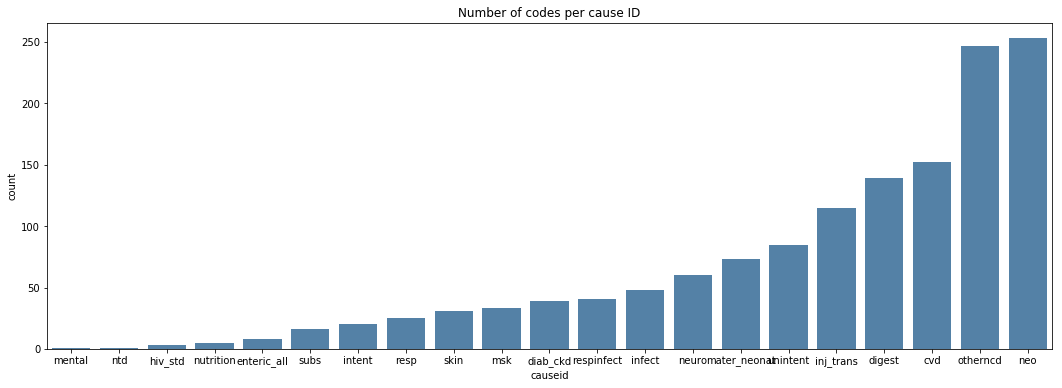

In [159]:
plt.figure(figsize=(18,6))
sns.countplot('causeid', data=df, order=df['causeid'].value_counts(ascending=True).index, color='steelblue')
plt.title('Number of codes per cause ID')
plt.show()

**INTERPRETATION**
They dataset is very unbalanced, as all cause IDs have very different number codes. This may become a problem for the cause IDs with the lowest counts, as the model may find it harder to detect patterns to classify future codes into these specific cause IDs.

___
## Data Pre-processing

### Data tokenization - convertion to bag-of-words

**This operation consists of converting a text in string format to a list of words (bag-of-words) where each word is considered as a token.**

This operation can be done in many ways, but here we will simply create a function that:

1. Remove all punctuation characters from all string text
2. Remove all stop words (i.e. most common words in the English language, as they could be present in all sample and may not contribute to any form of differentiation)

In [160]:
def text_tokenization(text):
    '''
    Remove punctuation and stopwords (i.e. common words) from a text (in string format)
    and returns a list of words from the cleaned text.
    Input:
        text: text in string format
    Output:
        cleaned_text: list of words (tokens) from the corresponding text, free of punctuation and stopwords
    '''
    # Remove all punctuation from text by looking at each character
    text_no_punc = [char.lower() for char in text if char not in string.punctuation]

    # Re-join all characters to re-form a string
    text_no_punc = ''.join(text_no_punc)
    
    # Remove all stopwords
    cleaned_text = [word for word in text_no_punc.split() if word.lower() not in stopwords.words('english')]
        
    return cleaned_text

### Vectorization

At this stage, all text data are represented by lists of tokens (also named _lemmas_), which require to be converted to some form of numerical vector in order to be processed by a machine learning algorithm.

This operation is called **Vectorization** and can be done using the _CountVectorizer_ tool from SciKit Learn, which will convert our lists of tokens into a (mxn) matrix of tokens counts as illustrated below:

| Entire vocabulary | Text 1 | Text 2 | ... | Text N |
|:---|:---:|:---:|:---:|:---:|
|Word 1 count | 1 | 0 | ... | 1 |
|Word 2 count | 0 | 1 | ... | 0 |
| ... | ... | ... | ... | ... |
| Word i count | 0 | 2 | ... | 0 |
| ... | ... | ... | ... | ... |
|Word M count | 1 | 0 | ... | 3 |

**Note:** Since this transformation usually results in a lot of zeros (as many text samples won't have a lot of words from the entire vocabulary), the _CountVectorizer_ tool from SciKit Learn will output a _Sparse Matrix_.

### Term frequency-inverse document frequency (TD-IDF) weights calculation

TD-IDF weight is a statistical measure used to evaluate how important a term/word is to a text/document in a collection or corpus (i.e. dataset). It is calculated as followed:

**1. Term frequency (TD):**

    TD(T) = ( Total counts of term T in a given document ) / ( Total number of terms in the same document )


**2. Inverse document frequency (IDF), which measures how import a term/word is based on how often it appears in the whole datatset (all texts/documents):**

    IDF(T) = log_e ( Total number of documents / Number of documents that have term T in them)

**TD-IDF = TD x IDF**

___
## Machine Learning

### Pipeline definition
**Create a pipeline that will:**
1. Vectorize the data
2. Calculate the TD-IDF weight of each word
3. Define the type of classifier for the machine learning algorithm

In terms of classifier, [Naive Bayes models](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf) models have been shown to perform quite well on text data. Therefore, we will use the _MultinomialNB_ model from SciKit Learn.

In [161]:
pipeline1 = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Model 1 - Trained using 'long_desc' column only
**Since the 'short_desc' and 'long_desc' columns seems indentical, and since the information provided by the 'sub_chapter' and 'chapter' columns seem to be the same for different cause IDs, we will start by training the algorithm using the data from the 'long_desc' column only.**

In [162]:
df = df[['causeid', 'long_desc']]

In [163]:
df.head()

,causeid,long_desc
0,respinfect,"Paratyphoid fever, unspecified"
1,infect,Salmonella sepsis
2,enteric_all,Enteroinvasive Escherichia coli infection
3,enteric_all,Other intestinal Escherichia coli infections
4,enteric_all,Campylobacter enteritis


### Text data tokenization

In [164]:
df['long_desc'] = df['long_desc'].apply(text_tokenization)
df.to_csv('processed-data/tokenized_long_desc.csv', index=False)

### Input data and labels definition

In [165]:
df = pd.read_csv('processed-data/tokenized_long_desc.csv')
X = df['long_desc']
y = df['causeid']

### Train/Test split

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Fit model to training data

In [167]:
pipeline1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Model evaluation

**Generate predictions.**

In [168]:
predictions = pipeline1.predict(X_test)

**Evaluate the model using classification report and confusion matrix:**

In [169]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test, predictions))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         cvd       0.85      0.82      0.84        56
    diab_ckd       1.00      0.47      0.64        15
      digest       0.78      0.73      0.76        49
     hiv_std       0.00      0.00      0.00         1
      infect       0.57      0.31      0.40        13
   inj_trans       0.80      1.00      0.89        32
      intent       0.00      0.00      0.00         8
mater_neonat       0.92      0.46      0.61        24
         msk       0.00      0.00      0.00        11
         neo       0.49      0.95      0.65        78
       neuro       0.50      0.06      0.10        18
   nutrition       0.00      0.00      0.00         3
    otherncd       0.60      0.77      0.67        91
        resp       0.00      0.00      0.00         9
  respinfect       1.00      0.25      0.40         8
        skin       0.00      0.00      0.00         7
        subs       0.00      0.00      0.00         7
   

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**INTERPRETATION**

The model did not perform so well on many cause IDs. What if we trained the model with additional information from the 'code', 'sub_chapter' and 'chapter' columns.

### Model 2 - Trained using 'code', 'long_desc', 'sub_chapter' and 'chapter' columns

In [170]:
df = pd.read_csv('deaths_icd10_descript.csv')

df = df.dropna()

df = df.drop(df[df['causeid']=='none'].index)

In [171]:
df.columns

Index(['code', 'causeid', 'short_desc', 'long_desc', 'three_digit',
       'sub_chapter', 'chapter'],
      dtype='object')

**Here, we will create a new column where the text of all selected columns will be aggregated.**

In [172]:
df['all_text'] = df[['code', 'long_desc', 'sub_chapter', 'chapter']].agg(' '.join, axis=1)
df = df[['causeid', 'all_text']]

In [173]:
df.head()

,causeid,all_text
0,respinfect,"A014 Paratyphoid fever, unspecified Intestinal..."
1,infect,A021 Salmonella sepsis Intestinal Infectious D...
2,enteric_all,A042 Enteroinvasive Escherichia coli infection...
3,enteric_all,A044 Other intestinal Escherichia coli infecti...
4,enteric_all,A045 Campylobacter enteritis Intestinal Infect...


**Next, we can apply the same steps as above to pre-process the data, then train and evaluate the model.**

In [174]:
df['all_text'] = df['all_text'].apply(text_tokenization)
df.to_csv('tokenized_data_all_text.csv', index=False)

In [175]:
df = pd.read_csv('processed-data/tokenized_data_all_text.csv')

X = df['all_text']
y = df['causeid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [176]:
pipeline2 = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [177]:
pipeline2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [178]:
predictions = pipeline2.predict(X_test)

In [179]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test, predictions))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         cvd       0.95      0.96      0.96        56
    diab_ckd       1.00      0.20      0.33        15
      digest       0.94      0.92      0.93        49
     hiv_std       0.00      0.00      0.00         1
      infect       0.71      0.77      0.74        13
   inj_trans       0.86      1.00      0.93        32
      intent       0.00      0.00      0.00         8
mater_neonat       0.96      1.00      0.98        24
         msk       0.78      0.64      0.70        11
         neo       0.89      0.99      0.93        78
       neuro       0.79      0.61      0.69        18
   nutrition       0.00      0.00      0.00         3
    otherncd       0.74      0.98      0.84        91
        resp       0.00      0.00      0.00         9
  respinfect       1.00      0.12      0.22         8
        skin       1.00      0.71      0.83         7
        subs       1.00      0.86      0.92         7
   

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**INTERPRETATION**

The model performed much better, especially on cause IDs that had higher counts.

## Garbage Codes
### Re-train model on complete dataset
**Splitting the data between train and test sets was only useful to evaluate the model performance on data that it had not seen. However, if we want to apply that model to new unlabelled data (such as garbage codes) we would benefit from re-training the model using the entire dataset.**

In [180]:
df = pd.read_csv('processed-data/tokenized_data_all_text.csv')

X = df['all_text']
y = df['causeid']

In [181]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [182]:
pipeline.fit(X,y)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Apply model to predict cause IDs on garbage codes
**First, we need to create the same 'all_text' column for the df_garbage dataset.**

In [183]:
df_garbage['all_text'] = df_garbage[['code', 'long_desc', 'sub_chapter', 'chapter']].agg(' '.join, axis=1)
df = df_garbage[['causeid', 'all_text']]

In [184]:
df.head()

,causeid,all_text
19,none,A170 Tuberculous meningitis Tuberculosis Certa...
20,none,A180 Tuberculosis of bones and joints Tubercul...
26,none,A310 Pulmonary mycobacterial infection Other B...
27,none,"A319 Mycobacterial infection, unspecified Othe..."
30,none,A390 Meningococcal meningitis Other Bacterial ...


**Next, we need to tokenize the garbage data so they can be used to build predictions.**

In [185]:
df['all_text'] = df['all_text'].apply(text_tokenization)
df.to_csv('processed-data/tokenized_garbage_data_all_text.csv', index=False)

c:\users\bdour\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [186]:
df = pd.read_csv('processed-data/tokenized_garbage_data_all_text.csv')
X = df['all_text']

**Now, let's generate predictions using the model trained on the entire labelled dataset.**

In [187]:
predictions = pipeline.predict(X)

**Finally, we will create a new dataframe that contains the predicted cause ID for all garbage codes, along with the information that were already provided ('short_desc', 'long_desc', etc.).

In [188]:
predicted_garbage = pd.DataFrame(predictions, columns=['predicted_causeid'])
df_garbage = df_garbage.reset_index()
predicted_garbage = pd.concat([predicted_garbage, df_garbage.drop('causeid', axis=1)], axis=1)
predicted_garbage = predicted_garbage.drop('index', axis=1)

predicted_garbage.to_csv('processed-data/predicted_garbage_code_causeid.csv', index=False)

In [189]:
predicted_garbage.head()

,predicted_causeid,code,short_desc,long_desc,three_digit,sub_chapter,chapter,all_text
0,infect,A170,Tuberculous meningitis,Tuberculous meningitis,A17,Tuberculosis,Certain infectious and parasitic diseases,A170 Tuberculous meningitis Tuberculosis Certa...
1,respinfect,A180,Tuberculosis of bones and joints,Tuberculosis of bones and joints,A18,Tuberculosis,Certain infectious and parasitic diseases,A180 Tuberculosis of bones and joints Tubercul...
2,infect,A310,Pulmonary mycobacterial infection,Pulmonary mycobacterial infection,A31,Other Bacterial Diseases,Certain infectious and parasitic diseases,A310 Pulmonary mycobacterial infection Other B...
3,infect,A319,"Mycobacterial infection, unspecified","Mycobacterial infection, unspecified",A31,Other Bacterial Diseases,Certain infectious and parasitic diseases,"A319 Mycobacterial infection, unspecified Othe..."
4,infect,A390,Meningococcal meningitis,Meningococcal meningitis,A39,Other Bacterial Diseases,Certain infectious and parasitic diseases,A390 Meningococcal meningitis Other Bacterial ...


___
## Conclusion
The second model trained on the ICD codes and their description performed well on most of the cause IDs that had larger counts (i.e. more ICD codes associated with them). This kind of modeling approach could largely be improved if more detailed descriptions were specified for each ICD codes.

Finally, since all garbage codes do not have a cause ID, the validity of the model when applied to garbage codes can only be determined manually by experts.